## Goal of this Notebook
In a similar fashion to how we used daily price movements to predict the following day's or weeks price movements, we will use intra-day range to predict the following day's price movement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats

In [2]:
df = pd.DataFrame()
df = df.from_csv('tsla.csv')

In [3]:
df.describe()

,close,volume,open,high,low
count,1803.000000,1.803000e+03,1803.000000,1803.000000,1803.000000
mean,144.444698,4.439461e+06,144.466594,146.920054,141.847566
std,102.990194,4.281379e+06,103.019791,104.429067,101.438157
min,15.800000,1.184140e+05,16.140000,16.630000,14.980000
25%,30.760000,1.267700e+06,30.605000,31.420000,29.885000
50%,178.560000,3.427251e+06,178.000000,181.730000,173.531000
75%,227.805000,5.963226e+06,227.975000,231.385000,224.120000
max,383.450000,3.710324e+07,386.690000,386.990000,379.345000


### 1)  Get the daily intra-day range of TSLA

In [4]:
def get_intra_day_range(df):
    intra_day_range = np.zeros(len(df))
    i = 0
    for index, row in df.iterrows():
        intra_day_range[i] = row['high'] - row['low']
        i += 1
    
    return intra_day_range

In [72]:
def get_intra_day_range_percentage(df):
    intra_day_range = np.zeros(len(df))
    i = 0
    for index, row in df.iterrows():
        intra_day_range[i] = 100 * (row['high'] - row['low']) / ((row['high'] + row['low']) / 2)
        i += 1
    
    return intra_day_range

In [67]:
df['Range'] = get_intra_day_range(df.sort_index(axis=0))

### 2) Plot Intra-Day Ranges

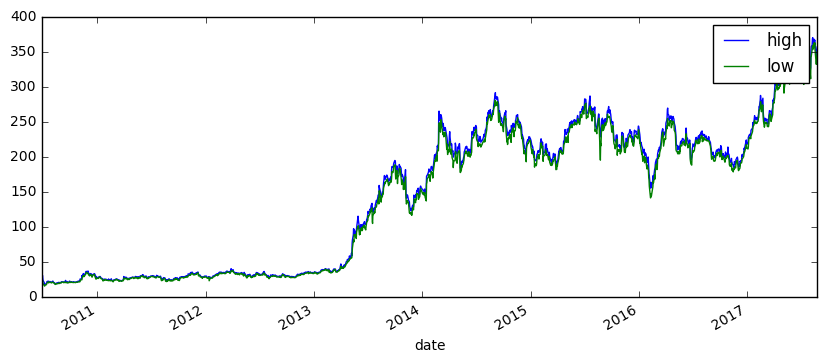

In [68]:
plt.figure(figsize=(10, 4))
df['high'].plot(label='high')
df['low'].plot(label='low')
plt.legend()
plt.show()

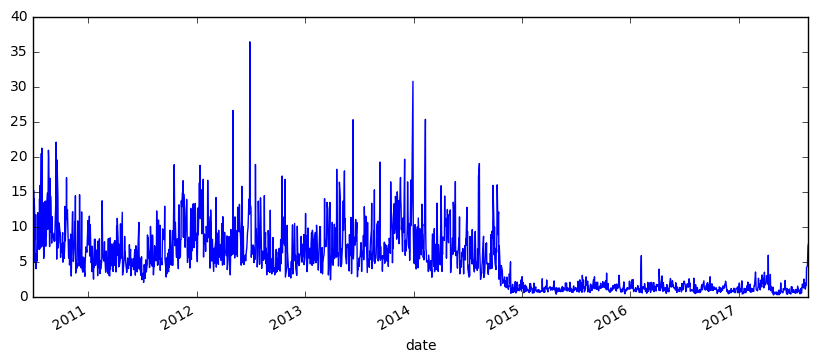

In [69]:
plt.figure(figsize=(10, 4))
df['Range'].plot()
plt.show()

In [13]:
df['Range'].min()

0.25

In [14]:
x = df['Range'].as_matrix()

In [15]:
min(x)

0.25

### 3) Plot the kernel density estimate for this stock
(Using the scipy default which is Scott's Rule) More info [here](https://en.wikipedia.org/wiki/Kernel_density_estimation)

In [32]:
def plot_gaussian(x, x_min=min(x), x_max=max(x), n=10000, fill=False, label=''):
    """ 
    Expects an np array of movement percentages, 
    plots the gaussian kernel density estimate
    """
    #x_min, x_max = min(x), max(x)
    
    ## Learn the kernel-density estimate from the data
    density = stats.gaussian_kde(x)
    
    ## Evaluate the output on some data points
    xs = np.linspace(x_min, x_max, n)
    y = density.evaluate(xs)
    
    ## Create the plot
    plt.plot(xs, y, label=label)
    plt.xlabel('Daily Intra-Day Range')
    plt.ylabel('Density')
    

    
    if (fill):
        plt.fill_between(xs, 0, y)

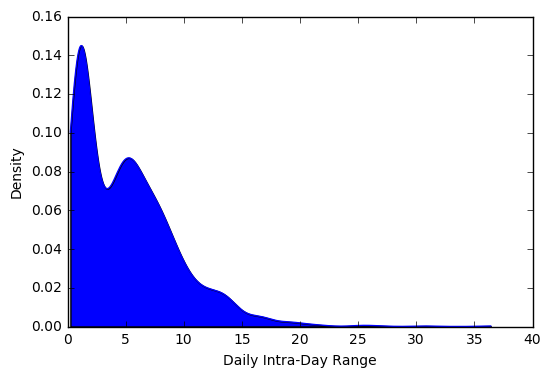

In [19]:
## Plot the output
plot_gaussian(x, fill=True)
plt.show()

In [20]:
print('The average inta-day range was ' + str(df['Range'].mean()) ) 
print('The standard deviation is ' + str(df['Range'].std()) ) 

The average inta-day range was 5.072487853577367
The standard deviation is 4.243341053753586


### 4) Get the Intra-Day Range of a few stocks

In [21]:
g = glob.glob('*.csv')

In [22]:
def ticker_from_csv(csv_string):
    stock_name = csv_string.rsplit('.', 1)[0] ## Peel off the ".csv"
    return stock_name.upper()

AMD
The average inta-day range was 0.25
The standard deviation is 0.19

BAC
The average inta-day range was 0.54
The standard deviation is 0.62

FB
The average inta-day range was 1.73
The standard deviation is 1.08

GOOG
The average inta-day range was 10.96
The standard deviation is 6.05

INTC
The average inta-day range was 0.52
The standard deviation is 0.26

MU
The average inta-day range was 0.49
The standard deviation is 0.31

NKE
The average inta-day range was 0.60
The standard deviation is 0.39

NVDA
The average inta-day range was 0.90
The standard deviation is 1.25

SBUX
The average inta-day range was 0.55
The standard deviation is 0.41

SPY
The average inta-day range was 1.87
The standard deviation is 1.26

TSLA
The average inta-day range was 5.07
The standard deviation is 4.24



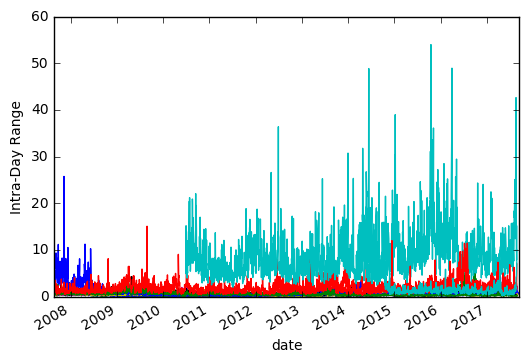

In [24]:
plt.figure()
for i in range(len(g)):
    df = pd.DataFrame()
    df = df.from_csv(g[i])
    ticker = ticker_from_csv(g[i])
    print(ticker)

    df['Range'] = get_intra_day_range(df.sort_index(axis=0)) ## Google finance data has dates in descending order, we don't want that
    print('The average inta-day range was ' + "{0:.2f}".format(df['Range'].mean())) 
    print('The standard deviation is ' + "{0:.2f}".format(df['Range'].std()) + '\n' ) 
    df['Range'].plot()

plt.ylabel('Intra-Day Range')
plt.show()

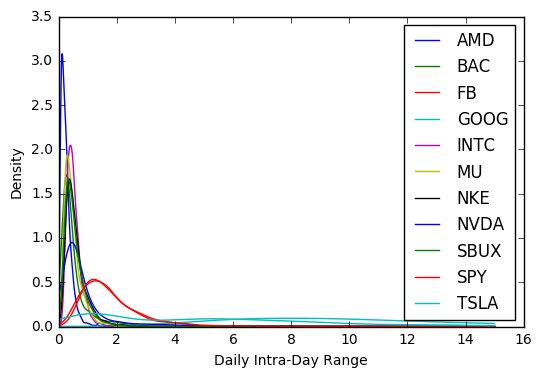

In [34]:
plt.figure(figsize=(10, 4))
for i in range(len(g)):
    df = pd.DataFrame()
    df = df.from_csv(g[i])
    ticker = ticker_from_csv(g[i])
    
    df['Range'] = get_intra_day_range(df.sort_index(axis=0))
    x = df['Range'].as_matrix()
    plot_gaussian(x, x_max=15, label=ticker)

plt.legend()
plt.show()

### 5) Viewing percentages might give us a better idea of scale

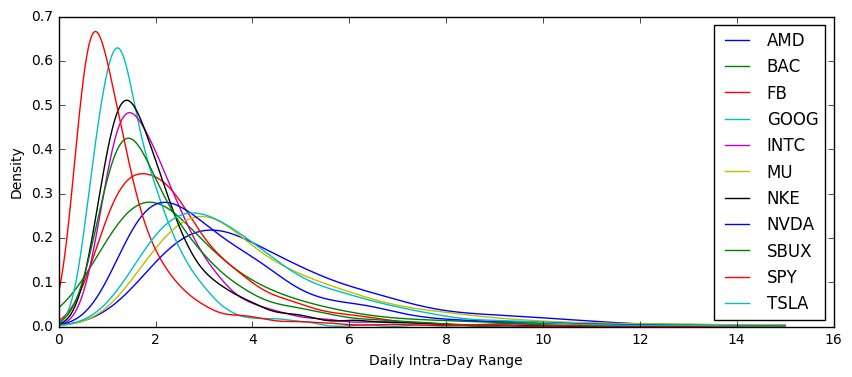

In [58]:
plt.figure(figsize=(10, 4))
for i in range(len(g)):
    df = pd.DataFrame()
    df = df.from_csv(g[i])
    ticker = ticker_from_csv(g[i])
    
    df['Range Percentage'] = get_intra_day_range_percentage(df.sort_index(axis=0))
    x = df['Range Percentage'].as_matrix()
    plot_gaussian(x, x_max=15, label=ticker)

plt.legend()
plt.show()

# Visualizing Intra-Day Range Categories
#### We would like to differentiate between the following price movement categories:

1. **Very Small**  
movement < mu - σ
2. **Small**  
movement < mu
3. **Large**  
movement > mu
4. **Very Large**  
movement > mu + σ


These categories are defined arbitrarily and can be changed if something more suitable or sensible is found.

In [51]:
def plot_gaussian_categorical(x, x_min=-10, x_max=10, n=10000, title=''):
    """
    Expects an np array of movement percentages, 
    plots the gaussian kernel density estimate
    """
    ## Learn the kernel-density estimate from the data
    density = stats.gaussian_kde(x)
    
    ## Evaluate the output on some data points
    xs = np.linspace(x_min, x_max, n)
    y = density.evaluate(xs)
    
    ## Create the plot
    plt.plot(xs, y)
    plt.xlabel('Daily Intra-Day Percentage')
    plt.ylabel('Density')
    
    ## Get stats
    mu, sigma = np.mean(x), np.std(x)
 
    ## Plot with conditionals
    plt.fill_between(xs, 0, y, where= xs < mu, facecolor='yellow', interpolate=True) ## Small
    plt.fill_between(xs, 0, y, where= xs < (mu - sigma), facecolor='orange', interpolate=True) ## Very Small
    
    plt.fill_between(xs, 0, y, where= xs > mu, facecolor='green', interpolate=True) ## Large
    plt.fill_between(xs, 0, y, where= xs > (mu + sigma), facecolor='blue', interpolate=True) ## Very Large
    
    ## Label mu and sigma
    plt.text(x_min + 1, max(y) * 0.8, r'$\mu$ = ' + '{0:.2f}'.format(mu))
    plt.text(x_min + 1, max(y) * 0.9, r'$\sigma$ = ' + '{0:.2f}'.format(sigma))
    ## Set title if given
    if (len(title) != 0):
        plt.title(title)

In [62]:
df['Range Percentage'] = get_intra_day_range_percentage(df.sort_index(axis=0))
x = df['Range Percentage'].as_matrix()
#x = df['Range'].as_matrix()

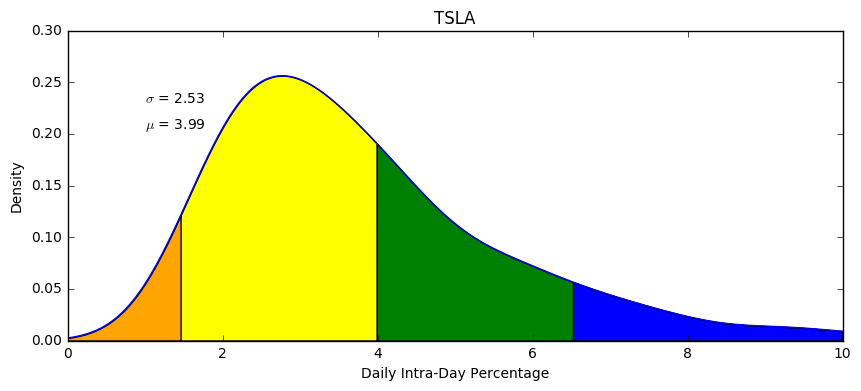

In [70]:
plt.figure(figsize=(10,4))
plot_gaussian_categorical(x, title='TSLA', x_min=0)
plt.show()

### Now lets try it with the rest of our stocks

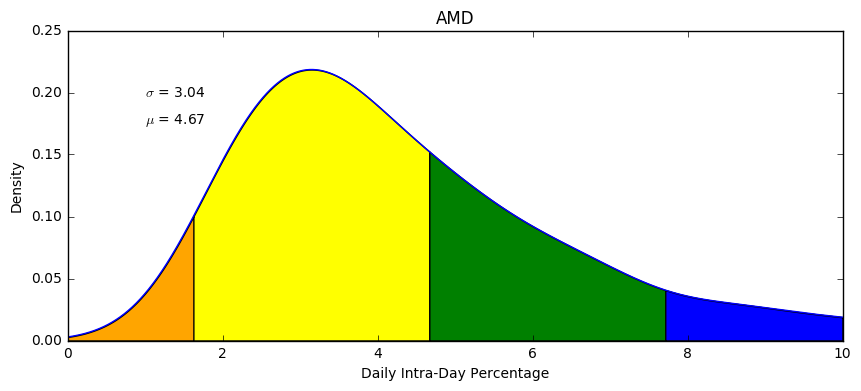

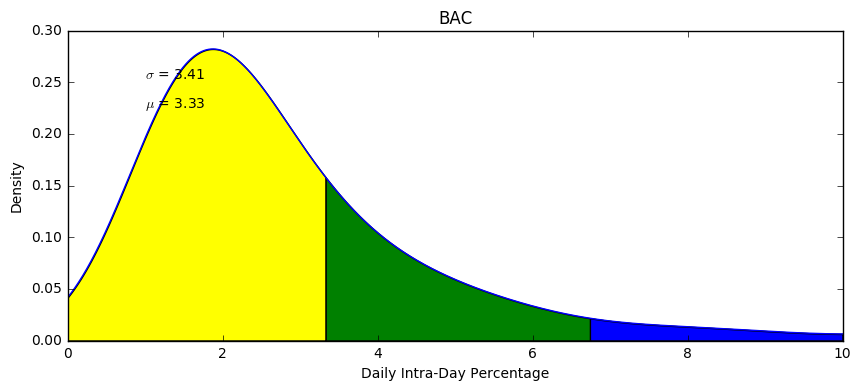

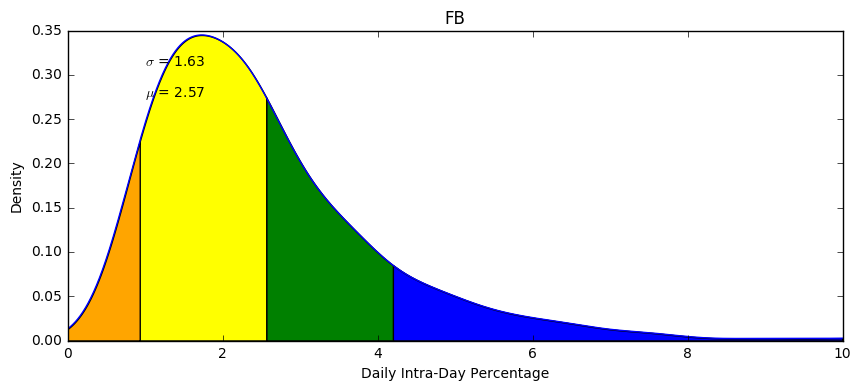

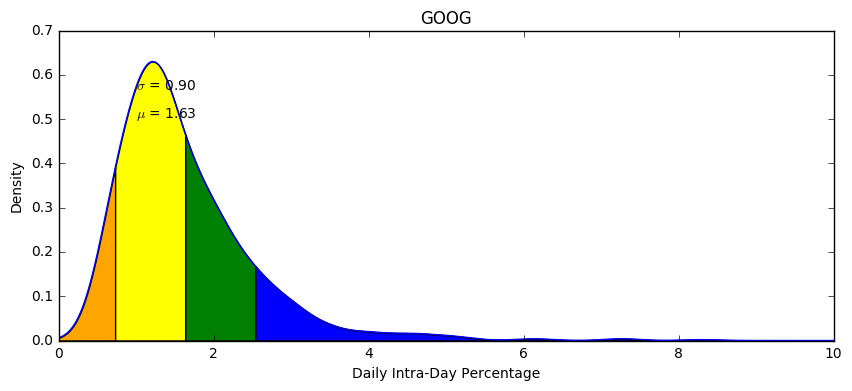

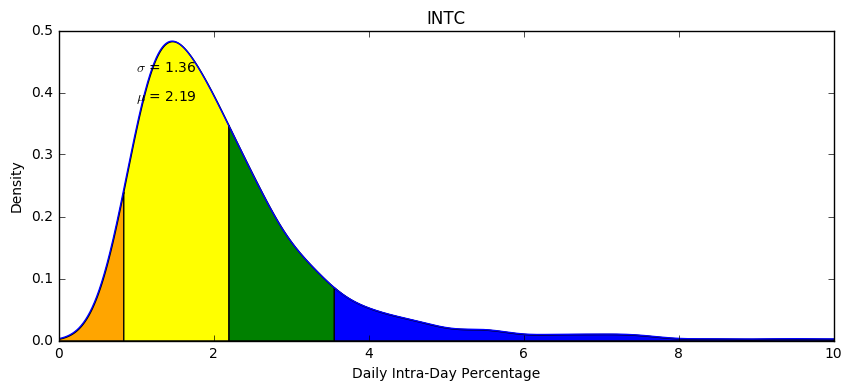

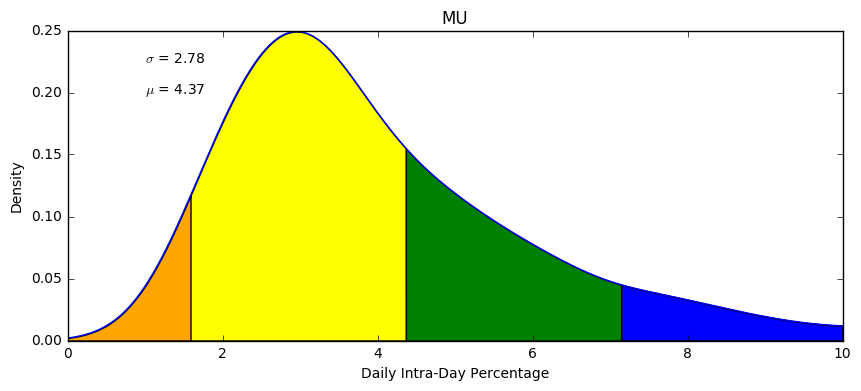

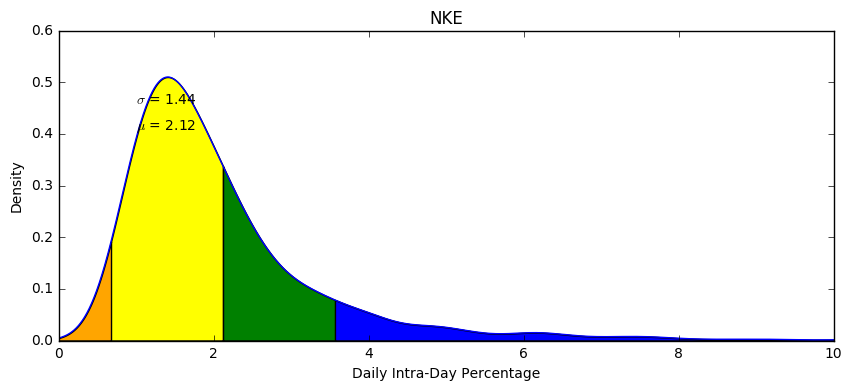

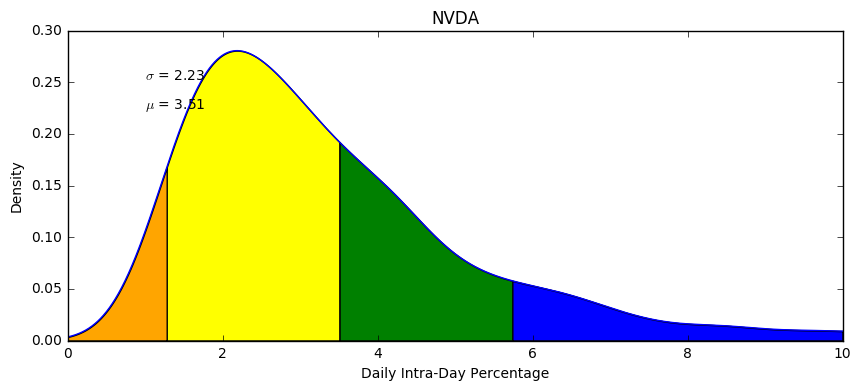

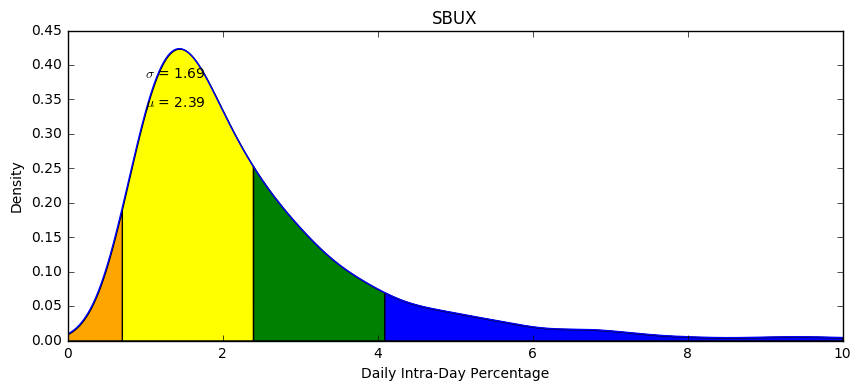

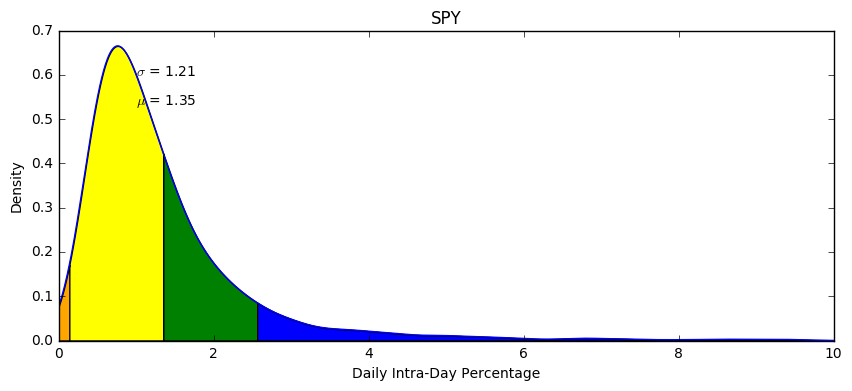

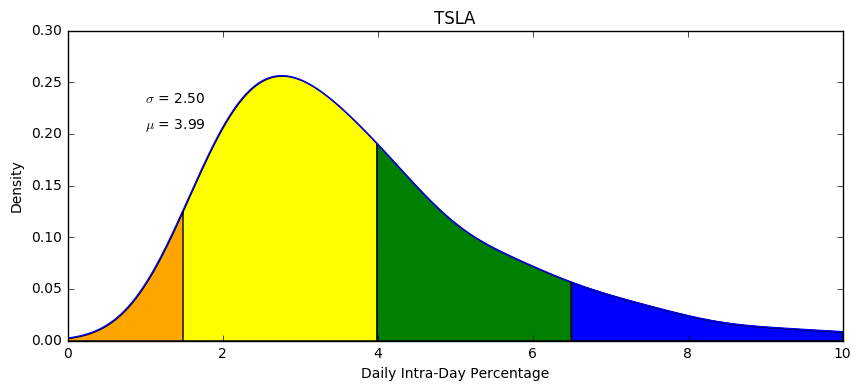

In [73]:
g = glob.glob('*.csv')

for i in range(len(g)):
    plt.figure(figsize=(10,4))
    df = pd.DataFrame()
    df = df.from_csv(g[i])
    x = get_intra_day_range_percentage(df.sort_index(axis=0))
    plot_gaussian_categorical(x, title=ticker_from_csv(g[i]), x_min=0)

plt.show()

# Predicting price movements of the next day given previos day's intra-day range
I would guess that intra-day range is a good proxy measure for volatilty, and therefore price movements will be more extreme the day after a wide range

In [76]:
from stock_utils import *

In [86]:
df = pd.DataFrame()
df = df.from_csv('nvda.csv')
## From now on, we will use percentage since it is normalzed across stock prices
daily_range_percentages = get_intra_day_range_percentage(df) 
daily_movements = get_price_movements(df)

In [88]:
def categorize_ranges(ranges):
    """Given an array of ranges, return an array of categories based on how relatively large the ranges are"""
    mu, sigma = np.mean(ranges), np.std(ranges)
    categories = []
    
    for i in range(len(ranges)):
        if (ranges[i] <= (mu - sigma)):
            categories.append('vs')  ## very small
        elif (ranges[i] < mu):
            categories.append('s')   ## small drop
        elif (ranges[i] >= (mu + sigma)):
            categories.append('vl')  ## very large
        elif (ranges[i] >= mu):
            categories.append('l')  ## small gain
        else:
            print("didn't fit")
    
    return categories

In [81]:
def count_range_category(categories, cat_to_count):
    count = 0
    for i in range(len(categories)):
        if categories[i] == cat_to_count:
            count = count + 1
    return count

In [82]:
def count_trends(trends, trend_to_count):
    count = 0
    for i in range(len(trends)):
        if trends[i] == trend_to_count:
            count = count + 1
    return count

In [91]:
def get_two_day_range_trends(range_categories, movement_categories):
    two_day_trends = []
    for i in range(len(range_categories) - 1):
        two_day_trends.append(range_categories[i] + '_' + movement_categories[i+1])
    return two_day_trends

In [92]:
range_categories = categorize_ranges(daily_range_percentage)
movement_categories = categorize_movements(daily_movements, n_cats=4)

In [94]:
two_day_range_trends = get_two_day_range_trends(range_categories, movement_categories)

In [102]:
vs_count = count_range_category(range_categories, 'vs')
s_count = count_range_category(range_categories, 's')
l_count = count_range_category(range_categories, 'l')
vl_count = count_range_category(range_categories, 'vl')

total_count = vs_count + s_count + l_count + vl_count

vs_prob = vs_count / total_count
s_prob = s_count / total_count
l_prob = l_count / total_count
vl_prob = vl_count / total_count

range_cat_probs = [vs_prob, s_prob, l_prob, vl_prob]

print('Number of very small range days: ' + str(vs_count))
print('Number of small range days: ' + str(s_count))
print('Number of large range days: ' + str(l_count))
print('Number of very large range days: ' + str(vl_count))

Number of very small range days: 112
Number of small range days: 1464
Number of large range days: 632
Number of very large range days: 312


In [113]:
## Movements
bd_count = count_movement_category(movement_categories, 'bd')
sd_count = count_movement_category(movement_categories, 'sd')
sg_count = count_movement_category(movement_categories, 'sg')
bg_count = count_movement_category(movement_categories, 'bg')

total_cat_count = len(categories)

p_bd = bd_count / total_cat_count
p_sd = sd_count / total_cat_count
p_sg = sg_count / total_cat_count
p_bg = bg_count / total_cat_count

movement_cat_probs = [p_bd, p_sd, p_sg, p_bg]

### Visuals

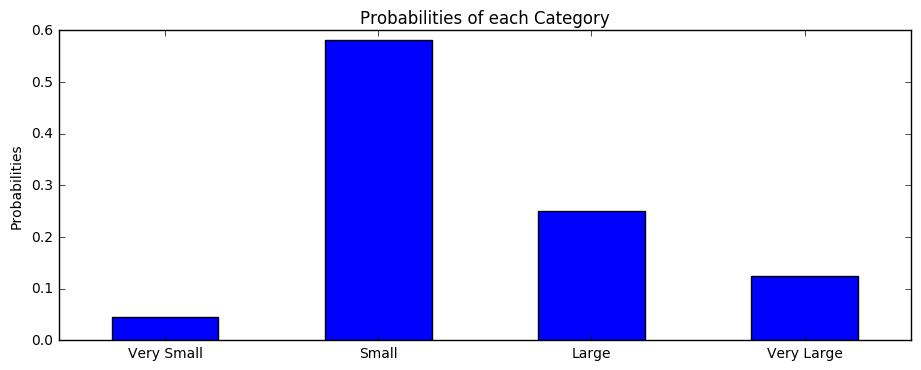

In [114]:
plt.figure(figsize=(11,4))
range_category_names = ('Very Small', 'Small', 'Large', 'Very Large')
ind = np.arange(4)
width = 0.5
p1 = plt.bar(ind, range_cat_probs, width, color='b', align='center')
plt.ylabel('Probabilities')
plt.title('Probabilities of each Category')
plt.xticks(ind, range_category_names)

plt.show()

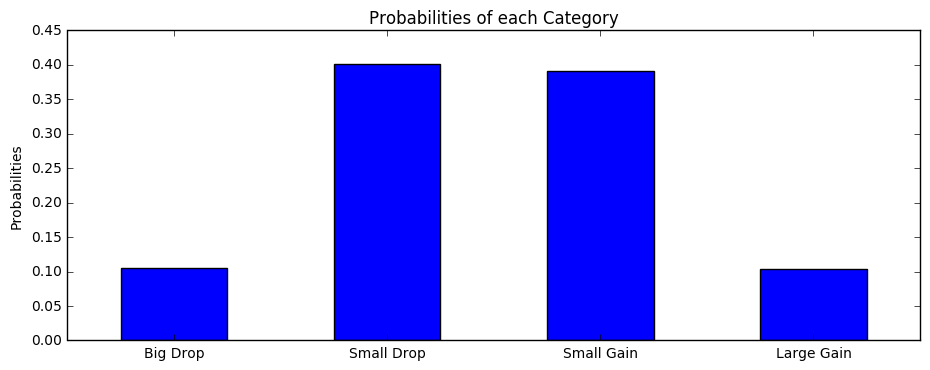

In [115]:
plt.figure(figsize=(11,4))
movement_category_names = ('Big Drop', 'Small Drop', 'Small Gain', 'Large Gain')
ind = np.arange(4)
width = 0.5
p1 = plt.bar(ind, movement_cat_probs, width, color='b', align='center')
plt.ylabel('Probabilities')
plt.title('Probabilities of each Category')
plt.xticks(ind, movement_category_names)

plt.show()

In [118]:
def plot_probability_bar_graph_ranges(name, count, two_day_trends, show_baseline=True, n_cats=4):
    two_day_probs = []
    if (n_cats != 4):
        raise ValueError('Only four categories are supported at this time')
        
    all_categories = ['bd', 'sd', 'sg', 'bg']
    for next_day in all_categories:
        two_day_name = name +'_' + next_day
        two_day_count = count_trends(two_day_range_trends, two_day_name)
        two_day_prob = two_day_count / count
        two_day_probs.append(two_day_prob)

    plt.figure(figsize=(11,4))
    movement_category_names = ('Big Drop', 'Small Drop', 'Small Gain', 'Big Gain')
    range_category_names = ('Very Small', 'Small', 'Large', 'Very Large')
    ind = np.arange(4)
    width = 0.25
    if (show_baseline):
        orig_pl = plt.bar(ind+width, movement_cat_probs, width, color='b', label='Original')
    conditioned_pl = plt.bar(ind, two_day_probs, width, color='r', label='After a ' + name)
    plt.ylabel('Probabilities')
    plt.title('Probabilities of each Category')
    plt.xticks(ind+width, movement_category_names)
    plt.legend()
    plt.show()

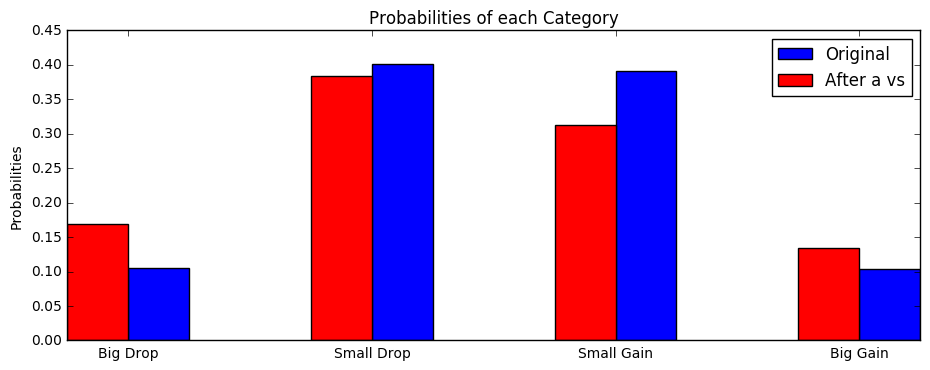

In [119]:
plot_probability_bar_graph_ranges('vs', vs_count, two_day_range_trends)